In [17]:
from pyexpat import features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from aiohttp.web_routedef import static
from mpmath import residual

df = pd.read_csv("/Users/lorenzoreinoso/Documents/MIT-StreetCar-Delay/dataset_with_has_delay.csv")

In [18]:
df.head()

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,has_delay,Year,Month,Day_of_Month,Hour,Minute,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W
0,1,0.126664,0.000992,11,10,20,4416,0,2024,1,1,2,45,0,0,0,0,1
1,1,0.126664,0.000361,3,52,72,4461,1,2024,1,1,3,6,0,1,0,0,0
2,1,0.064381,0.000180,11,0,0,4545,0,2024,1,1,3,21,0,0,1,0,0
3,1,0.126664,0.020566,11,37,0,4551,1,2024,1,1,3,53,0,0,0,0,1
4,1,0.002645,0.005412,2,78,93,8116,1,2024,1,1,4,27,0,1,0,0,0


In [19]:
df["Min Delay"].value_counts()

Min Delay
10     3804
0      1859
8       618
5       553
9       328
       ... 
358       1
873       1
196       1
308       1
640       1
Name: count, Length: 197, dtype: int64

In [20]:
df["Year"].value_counts()

Year
2024    11086
Name: count, dtype: int64

In [21]:
df.drop("Year", axis=1, inplace=True)  # axis=1 is preferred over axis="1"
df.head()

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,has_delay,Month,Day_of_Month,Hour,Minute,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W
0,1,0.126664,0.000992,11,10,20,4416,0,1,1,2,45,0,0,0,0,1
1,1,0.126664,0.000361,3,52,72,4461,1,1,1,3,6,0,1,0,0,0
2,1,0.064381,0.000180,11,0,0,4545,0,1,1,3,21,0,0,1,0,0
3,1,0.126664,0.020566,11,37,0,4551,1,1,1,3,53,0,0,0,0,1
4,1,0.002645,0.005412,2,78,93,8116,1,1,1,4,27,0,1,0,0,0


In [22]:
df['TimeOfDay'] = df['Hour'] * 60 + df['Minute']
df.drop("Hour", axis=1, inplace=True)
df.drop("Minute", axis=1, inplace=True)
df.drop("has_delay", axis=1, inplace=True)
features = ['Week', 'Line', 'Location', 'Incident', 'TimeOfDay', 'Vehicle', 'Month', 'Day_of_Month',
               'Bound_B', 'Bound_E', 'Bound_N', 'Bound_S', 'Bound_W']

In [23]:
df.corr()

,Week,Line,Location,Incident,Min Delay,Min Gap,Vehicle,Month,Day_of_Month,Bound_B,Bound_E,Bound_N,Bound_S,Bound_W,TimeOfDay
Week,1.000000,-0.020557,-0.009163,-0.034631,0.024939,0.020689,-0.060901,0.993460,0.133731,-0.013101,-0.006704,0.019671,-0.011252,0.006088,0.030967
Line,-0.020557,1.000000,0.013687,0.028875,-0.004731,0.001470,0.128248,-0.021900,0.009139,-0.007813,0.046890,-0.015952,-0.031101,0.058818,0.059876
Location,-0.009163,0.013687,1.000000,0.018223,-0.061398,-0.059584,0.010238,-0.008355,-0.007077,-0.009415,-0.119160,0.028824,0.054972,-0.096921,-0.039517
Incident,-0.034631,0.028875,0.018223,1.000000,-0.135734,-0.140222,0.059059,-0.035929,0.010761,-0.015963,-0.028856,0.017257,0.018055,-0.028703,-0.059952
Min Delay,0.024939,-0.004731,-0.061398,-0.135734,1.000000,0.963514,-0.047443,0.025508,-0.003235,-0.004101,0.033471,-0.022565,-0.038515,0.012643,-0.006342
Min Gap,0.020689,0.001470,-0.059584,-0.140222,0.963514,1.000000,-0.043295,0.021665,-0.006595,-0.006881,0.036256,-0.024671,-0.039615,0.023154,-0.013630
Vehicle,-0.060901,0.128248,0.010238,0.059059,-0.047443,-0.043295,1.000000,-0.062635,0.004764,-0.006371,0.036593,0.045068,0.021448,0.030474,0.007701
Month,0.993460,-0.021900,-0.008355,-0.035929,0.025508,0.021665,-0.062635,1.000000,0.022706,-0.013953,-0.008164,0.022919,-0.010715,0.005424,0.028989
Day_of_Month,0.133731,0.009139,-0.007077,0.010761,-0.003235,-0.006595,0.004764,0.022706,1.000000,0.005532,0.009078,-0.025333,-0.002130,0.006074,0.020246
Bound_B,-0.013101,-0.007813,-0.009415,-0.015963,-0.004101,-0.006881,-0.006371,-0.013953,0.005532,1.000000,-0.014392,-0.007671,-0.007766,-0.014329,-0.013444


<Axes: >

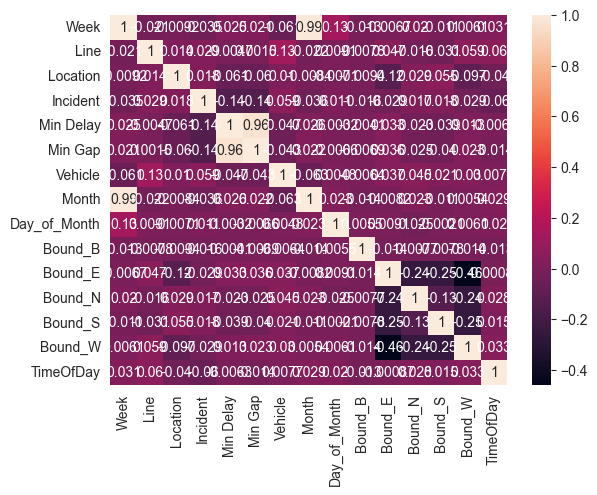

In [24]:
sns.heatmap(df.corr(),annot=True)

<Axes: xlabel='Min Delay', ylabel='Density'>

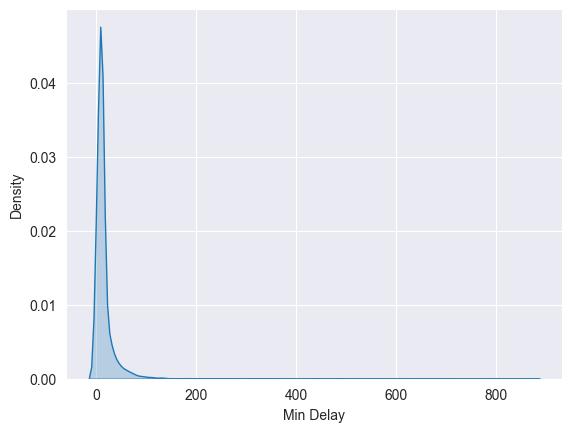

In [25]:
sns.kdeplot(df,x="Min Delay", fill=True)

<Axes: ylabel='Min Delay'>

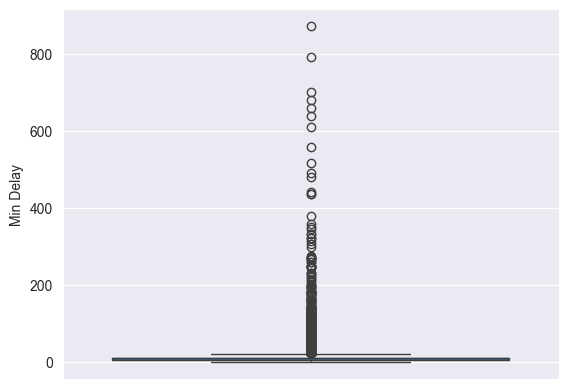

In [26]:
sns.boxplot(df,y="Min Delay")

In [27]:
df[['Min Delay', 'Min Gap']].describe()

,Min Delay,Min Gap
count,11086.000000,11086.000000
mean,15.443532,23.237958
std,32.338755,34.076949
min,0.000000,0.000000
25%,5.000000,10.000000
50%,10.000000,20.000000
75%,12.000000,21.000000
max,873.000000,883.000000


In [28]:
df['Min Delay'].corr(df['Min Gap'])
correlation = df['Min Delay'].corr(df['Min Gap'])
print(f"\nCorrelation between Min Delay and Min Gap: {correlation:.2f}")


Correlation between Min Delay and Min Gap: 0.96


In [29]:
df.drop("Min Gap", axis=1, inplace=True)


In [31]:
#sns.boxplot(df,y="Min Gap", hue="Min Delay")

In [32]:
X = df.drop(df.columns[-1],axis=1)
y = df['Min Delay']

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.pipeline import Pipeline

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipelines for different models
pipelines = {
    'rf': Pipeline([
        ('scaler', RobustScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'gb': Pipeline([
        ('scaler', RobustScaler()),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'xgb': Pipeline([
        ('scaler', RobustScaler()),
        ('model', xgb.XGBRegressor(random_state=42))
    ])
}

# Define parameter grids for each model
param_grids = {
    'rf': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5]
    },
    'gb': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'xgb': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}

# Train and evaluate models
best_models = {}
results = {}

for name, pipeline in pipelines.items():
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    results[name] = {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'best_params': grid_search.best_params_
    }

# Find best model
best_model_name = min(results, key=lambda x: results[x]['rmse'])
best_model = best_models[best_model_name]

# Print results
for name in results:
    print(f"\n{name.upper()} Results:")
    print(f"RMSE: {results[name]['rmse']:.2f}")
    print(f"R2 Score: {results[name]['r2']:.2f}")
    print("Best Parameters:", results[name]['best_params'])

print(f"\nBest Model: {best_model_name.upper()}")


RF Results:
RMSE: 4.21
R2 Score: 0.99
Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}

GB Results:
RMSE: 2.28
R2 Score: 1.00
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}

XGB Results:
RMSE: 2.19
R2 Score: 1.00
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}

Best Model: XGB


Realizando análisis exploratorio...


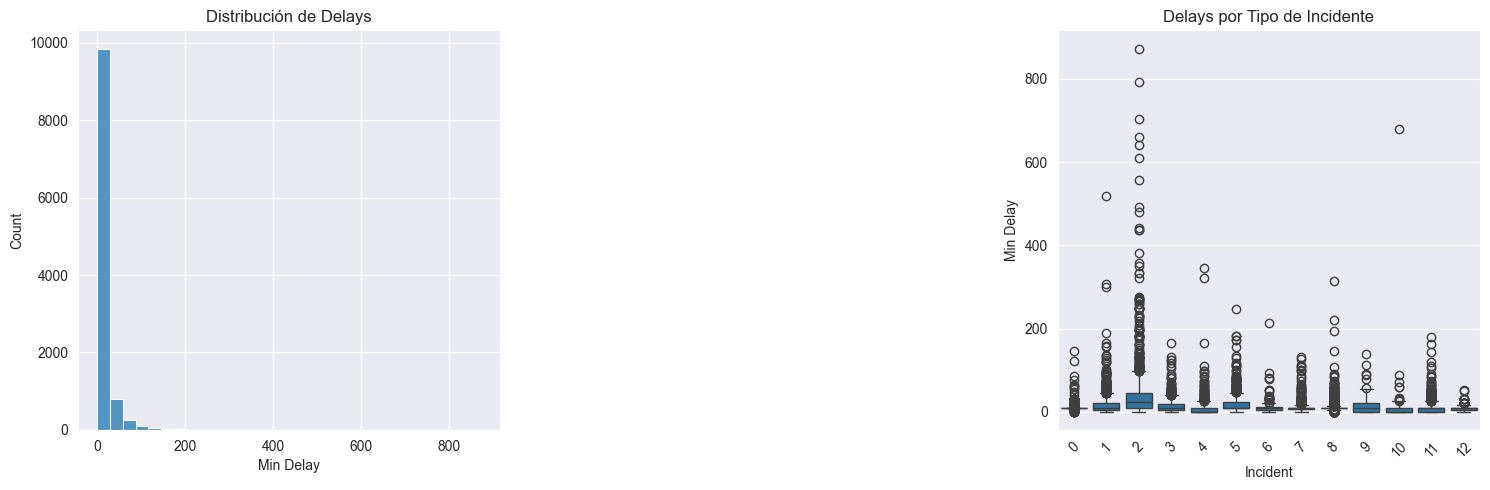

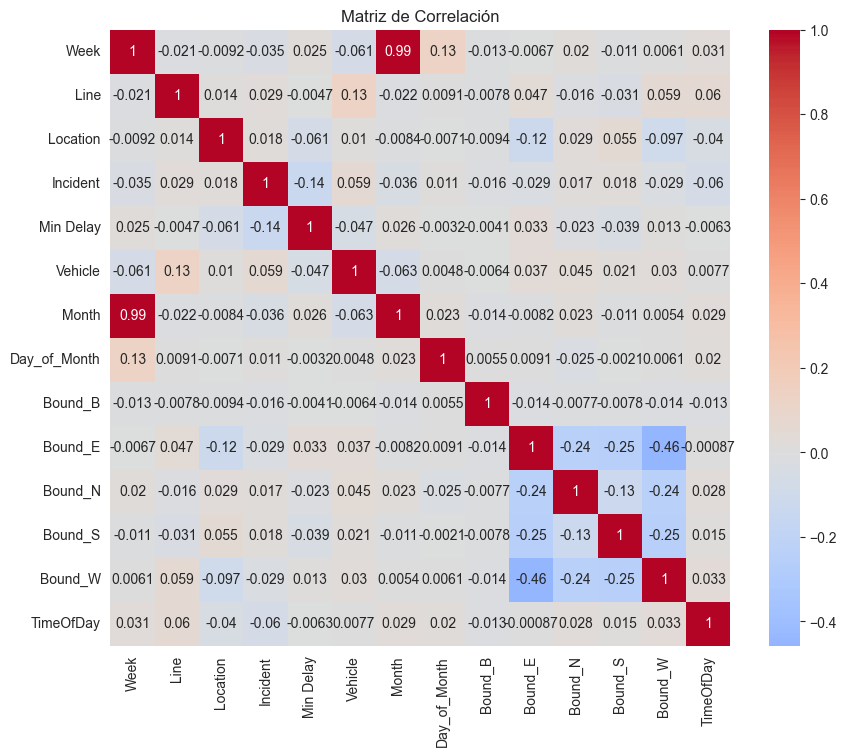

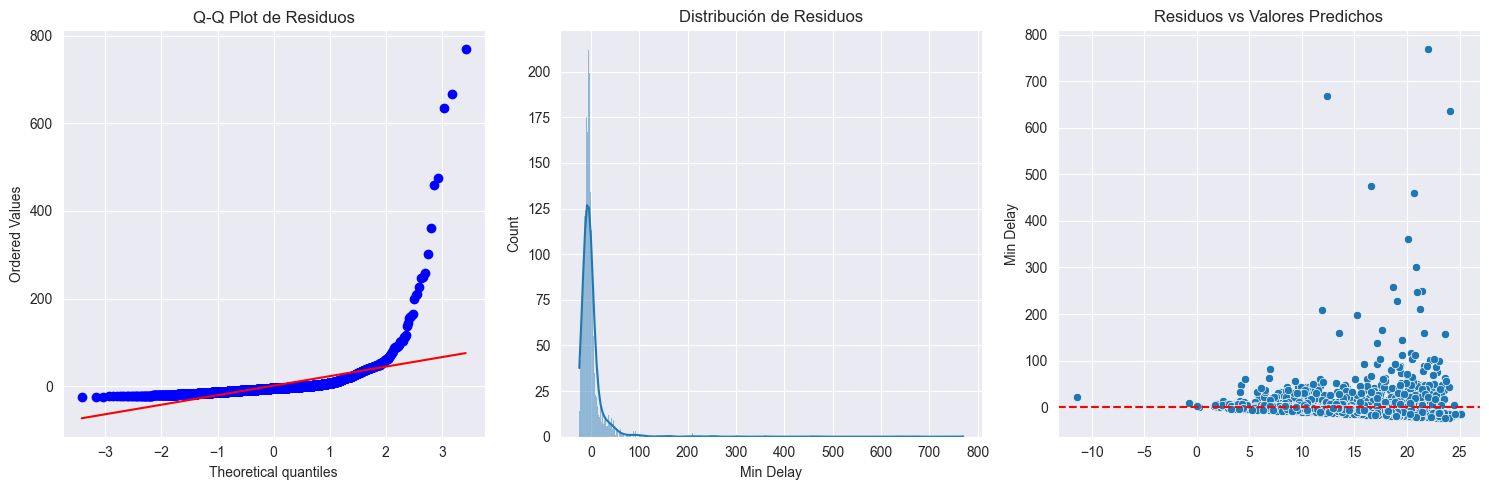


Test de Shapiro-Wilk para Normalidad:
Estadístico: 0.3247
P-valor: 0.0000


ValueError: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan

def exploratory_analysis(df):
    plt.figure(figsize=(15, 5))

    # Distribución de delays
    plt.subplot(131)
    sns.histplot(data=df, x='Min Delay', bins=30)
    plt.title('Distribución de Delays')

    # Delays por tipo de incidente
    plt.subplot(133)
    sns.boxplot(data=df, x='Incident', y='Min Delay')
    plt.xticks(rotation=45)
    plt.title('Delays por Tipo de Incidente')

    plt.tight_layout()
    plt.show()

    # Matriz de correlación
    plt.figure(figsize=(10, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación')
    plt.show()

def check_model_assumptions(y_true, y_pred, residuals):
    fig = plt.figure(figsize=(15, 5))

    # Q-Q plot
    ax1 = fig.add_subplot(131)
    stats.probplot(residuals, dist="norm", plot=ax1)
    ax1.set_title("Q-Q Plot de Residuos")

    # Histograma de residuos
    ax2 = fig.add_subplot(132)
    sns.histplot(residuals, kde=True, ax=ax2)
    ax2.set_title("Distribución de Residuos")

    # Residuos vs Valores Predichos
    ax3 = fig.add_subplot(133)
    sns.scatterplot(x=y_pred, y=residuals, ax=ax3)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_title("Residuos vs Valores Predichos")

    plt.tight_layout()
    plt.show()

    # Test de Shapiro-Wilk
    shapiro_test = stats.shapiro(residuals)
    print("\nTest de Shapiro-Wilk para Normalidad:")
    print(f"Estadístico: {shapiro_test[0]:.4f}")
    print(f"P-valor: {shapiro_test[1]:.4f}")

    # Test de Breusch-Pagan para homocedasticidad
    # Preparar los datos para el test
    X = y_pred.reshape(-1, 1)  # Variables independientes
    bp_test = het_breuschpagan(residuals, X)
    print("\nTest de Breusch-Pagan para Homocedasticidad:")
    print(f"Estadístico: {bp_test[0]:.4f}")
    print(f"P-valor: {bp_test[1]:.4f}")


# Preparar los datos
df_clean = df

# Realizar análisis exploratorio
print("Realizando análisis exploratorio...")
exploratory_analysis(df_clean)

# Preparar variables para el modelo
X = df_clean[features]
y = df_clean['Min Delay']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calcular residuos
residuos = y_test - y_pred_test

# Verificar supuestos del modelo
check_model_assumptions(y_test, y_pred_test, residuos)
